In [194]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jre_utils.datapath import (
    factor_data_paths,
    model_ready_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
)

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay, r2_score

from jre_utils.datapath import WEIGHTS_DIRECTORY_PATH

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [196]:
asset_type = "building"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

dataset_paths = {
    "transactions": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = "weighted_median_smoothed"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric
upcoming_metric_pct_chg = "upcoming_" + metric_pct_chg
normalized_upcoming_metric_pct_chg = "normalized_" + "upcoming_" + metric_pct_chg

In [197]:
dataset_key = "transactions"
years_ahead = 2
model_ready_data_path = model_ready_data_paths[f"xgb_{dataset_key}_{metric_key}_{years_ahead}"]

df = pd.read_csv(model_ready_data_path)
df[normalized_upcoming_metric_pct_chg] = df.groupby("year")[
    upcoming_metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

KeyError: 'xgb_transactions_weighted_median_smoothed_2'

In [198]:
# y_columns = [upcoming_metric_pct_chg]
y_columns = [normalized_upcoming_metric_pct_chg]

X_categorical_columns = ["area_code", "area"]

X_basic_columns = [
    "year",
    "years_since_crisis",
    "population",
    "count",
    "taxable_income_per_taxpayer",
    "taxable_income_per_taxpayer_growth",
    "total_tax",
    "migrations_is_available",
    "taxable_income_is_available",
    "total_tax_is_available",
    "dwellings_is_available",
]

X_engineering_columns = [
    "net_migration_ratio",
    "taxable_income_growth",
    "new_dwellings_ratio",
    "total_tax_growth",
    metric_pct_chg,
]

# X_engineered_columns = [
#     "net_migration_ratio_ma3",
#     "net_migration_ratio_cumu3",
#     "net_migration_ratio_lag1",
#     # "taxable_income_growth_ma3",
#     # "taxable_income_growth_cumu3",
#     # "taxable_income_growth_lag1",
#     "new_dwellings_ratio_ma3",
#     "new_dwellings_ratio_cumu3",
#     "new_dwellings_ratio_lag1",
#     "total_tax_growth_ma3",
#     "total_tax_growth_cumu3",
#     "total_tax_growth_lag1",
#     "unit_price_median_pct_chg_ma3",
#     "unit_price_median_pct_chg_cumu3",
#     "unit_price_median_pct_chg_lag1",
# ]

X_engineered_columns = [
    "net_migration_ratio_ma3",
    "net_migration_ratio_cumu3",
    "net_migration_ratio_lag1",
    "net_migration_ratio_lag2",
    "net_migration_ratio_lag3",
    "taxable_income_growth_ma3",
    "taxable_income_growth_cumu3",
    "taxable_income_growth_lag1",
    "taxable_income_growth_lag2",
    "taxable_income_growth_lag3",
    "new_dwellings_ratio_ma3",
    "new_dwellings_ratio_cumu3",
    "new_dwellings_ratio_lag1",
    "new_dwellings_ratio_lag2",
    "new_dwellings_ratio_lag3",
    "total_tax_growth_ma3",
    "total_tax_growth_cumu3",
    "total_tax_growth_lag1",
    "total_tax_growth_lag2",
    "total_tax_growth_lag3",
    "unit_price_wmedian_smoothed_pct_chg_ma3",
    "unit_price_wmedian_smoothed_pct_chg_cumu3",
    "unit_price_wmedian_smoothed_pct_chg_lag1",
    "unit_price_wmedian_smoothed_pct_chg_lag2",
    "unit_price_wmedian_smoothed_pct_chg_lag3",
]

X_columns = (
    X_categorical_columns
    + X_basic_columns
    + X_engineering_columns
    + X_engineered_columns
)

In [199]:
divide_year = 2019 # test_years = [2021]
end_year = 2021
train_df = df[df["year"] <= divide_year]
test_df = df[(df["year"] > divide_year) & (df["year"] <= end_year)]

# test_year = 2015
# train_df = df[df["year"] != test_year]
# test_df = df[df["year"] == test_year]

drop_columns = ["year", "area_code", "area"]
X_train_df, X_test_df = train_df[X_columns].drop(columns=drop_columns), test_df[X_columns].drop(columns=drop_columns)
y_train_df, y_test_df = train_df[y_columns], test_df[y_columns]

In [200]:
test_df

,area_code,area,year,years_since_crisis,population,count,total_traded_area,taxable_income_per_taxpayer,taxable_income_per_taxpayer_growth,total_tax,migrations_is_available,taxable_income_is_available,total_tax_is_available,dwellings_is_available,net_migration_ratio,taxable_income_growth,new_dwellings_ratio,total_tax_growth,unit_price_wmedian_smoothed_pct_chg,upcoming_unit_price_wmedian_smoothed_pct_chg,multiplier,net_migration_ratio_ma3,net_migration_ratio_cumu3,net_migration_ratio_lag1,taxable_income_growth_ma3,taxable_income_growth_cumu3,taxable_income_growth_lag1,new_dwellings_ratio_ma3,new_dwellings_ratio_cumu3,new_dwellings_ratio_lag1,total_tax_growth_ma3,total_tax_growth_cumu3,total_tax_growth_lag1,unit_price_wmedian_smoothed_pct_chg_ma3,unit_price_wmedian_smoothed_pct_chg_cumu3,unit_price_wmedian_smoothed_pct_chg_lag1,net_migration_ratio_lag2,net_migration_ratio_lag3,taxable_income_growth_lag2,taxable_income_growth_lag3,new_dwellings_ratio_lag2,new_dwellings_ratio_lag3,total_tax_growth_lag2,total_tax_growth_lag3,unit_price_wmedian_smoothed_pct_chg_lag2,unit_price_wmedian_smoothed_pct_chg_lag3,normalized_upcoming_unit_price_wmedian_smoothed_pct_chg
11,23441,Aichi-ken Agui-cho,2020,1,28383.0,18.0,5035.0,3423.942896,-0.001035,4221914.0,1,1,1,0,-0.001585,0.002647,0.000000,-0.005192,0.111647,-0.035828,1.111647,-0.001886,0.994351,-0.002916,0.011240,1.034044,0.016125,0.000000,1.000000,0.000000,0.008402,1.024849,-0.005558,0.020898,1.038669,0.107039,-0.001158,0.004158,0.014948,0.022260,0.000000,0.000000,0.035955,-0.002336,-0.155991,-0.339723,-0.291776
12,23441,Aichi-ken Agui-cho,2021,2,28421.0,25.0,5990.0,3460.559927,0.010694,4072735.0,1,1,1,0,0.001337,0.000999,0.000000,-0.035334,-0.070060,0.029615,0.929940,-0.001055,0.996834,-0.001585,0.006591,1.019833,0.002647,0.000000,1.000000,0.000000,-0.015361,0.954324,-0.005192,0.049542,1.144419,0.111647,-0.002916,-0.001158,0.016125,0.014948,0.000000,0.000000,-0.005558,0.035955,0.107039,-0.155991,-0.187055
28,23232,Aichi-ken Aisai-shi,2020,1,60829.0,63.0,16680.0,3151.788976,-0.044940,7746744.0,1,1,1,1,0.000099,-0.040435,0.010437,-0.016919,-0.097922,0.424788,0.902078,-0.001038,0.996887,-0.000362,0.012286,1.034662,0.061548,0.012846,1.039031,0.014617,0.004315,1.012603,0.022498,-0.088675,0.750012,-0.170857,-0.002851,-0.001930,0.015744,0.015668,0.013485,0.010949,0.007366,0.016338,0.002755,0.334818,0.853003
29,23232,Aichi-ken Aisai-shi,2021,2,60698.0,70.0,18530.0,3143.470864,-0.002639,7662720.0,1,1,1,1,-0.002158,0.000115,0.013938,-0.010846,0.124875,0.571294,1.124875,-0.000807,0.997579,0.000099,0.007076,1.018741,-0.040435,0.012997,1.039496,0.010437,-0.001756,0.994296,-0.016919,-0.047968,0.841352,-0.097922,-0.000362,-0.002851,0.061548,0.015744,0.014617,0.013485,0.022498,0.007366,-0.170857,0.002755,0.555469
45,23237,Aichi-ken Ama-shi,2020,1,86126.0,111.0,23425.0,3300.948469,0.021759,11242246.0,1,1,1,1,-0.000952,0.031202,0.013064,0.015594,-0.201169,0.325929,0.798831,0.000800,1.002400,0.002013,0.025774,1.079304,0.020886,0.016029,1.048854,0.016043,0.013879,1.042178,0.006951,-0.082678,0.757490,-0.097164,0.001340,0.000560,0.025233,0.021836,0.018980,0.014779,0.019092,0.029976,0.050300,0.063172,0.607308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24768,19212,Yamanashi-ken Uenohara-shi,2021,2,22642.0,11.0,4620.0,2994.759034,0.026115,3129643.0,1,1,1,1,-0.001192,-0.000960,0.004741,-0.007267,0.289307,1.210880,1.289307,-0.005087,0.984804,-0.007279,-0.001999,0.993339,-0.028526,0.004736,1.014277,0.004600,-0.009566,0.971538,-0.016476,-0.220902,0.336665,-0.360036,-0.006791,-0.003884,0.023490,-0.025876,0.004868,0.004146,-0.004955,0.002180,-0.591976,-0.565601,1.432201
24784,19425,Yamanashi-ken Yamanakako-mura,2020,1,5179.0,15.0,11530.0,3174.126143,-0.051355,2468379.0,1,1,1,0,0.006565,-0.063679,0.000000,-0.110067,0.439651,0.169147,1.439651,-0.003465,0.989560,-0.005950,-0.

In [201]:
X_train_df.shape, y_train_df.shape

((19438, 40), (19438, 1))

<Axes: ylabel='Frequency'>

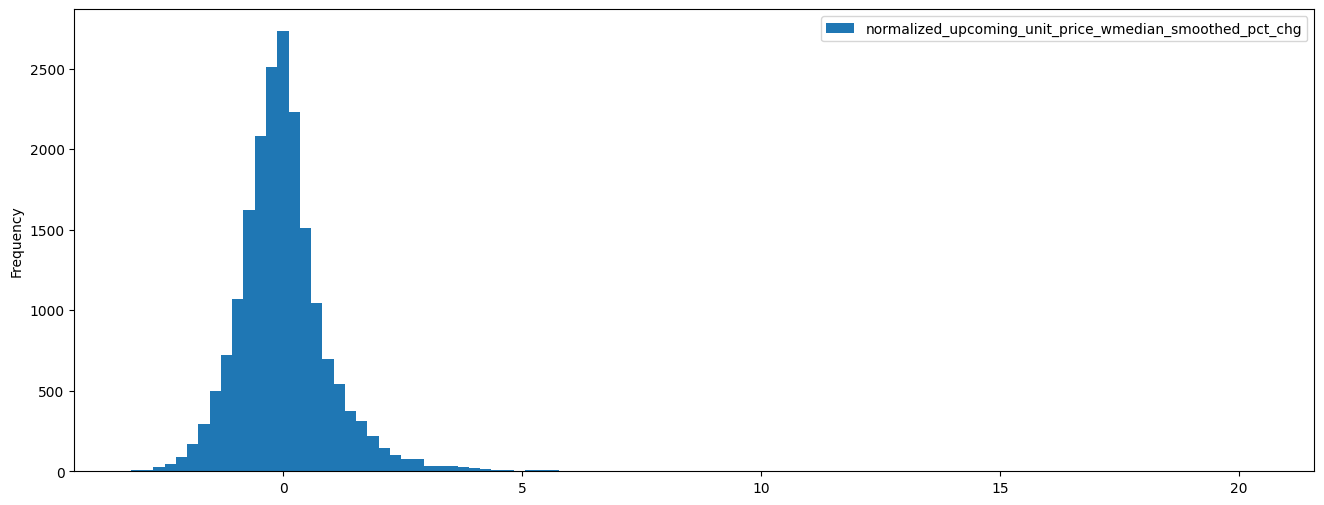

In [202]:
y_train_df.plot.hist(bins=100, figsize=(16, 6))

<Axes: ylabel='Frequency'>

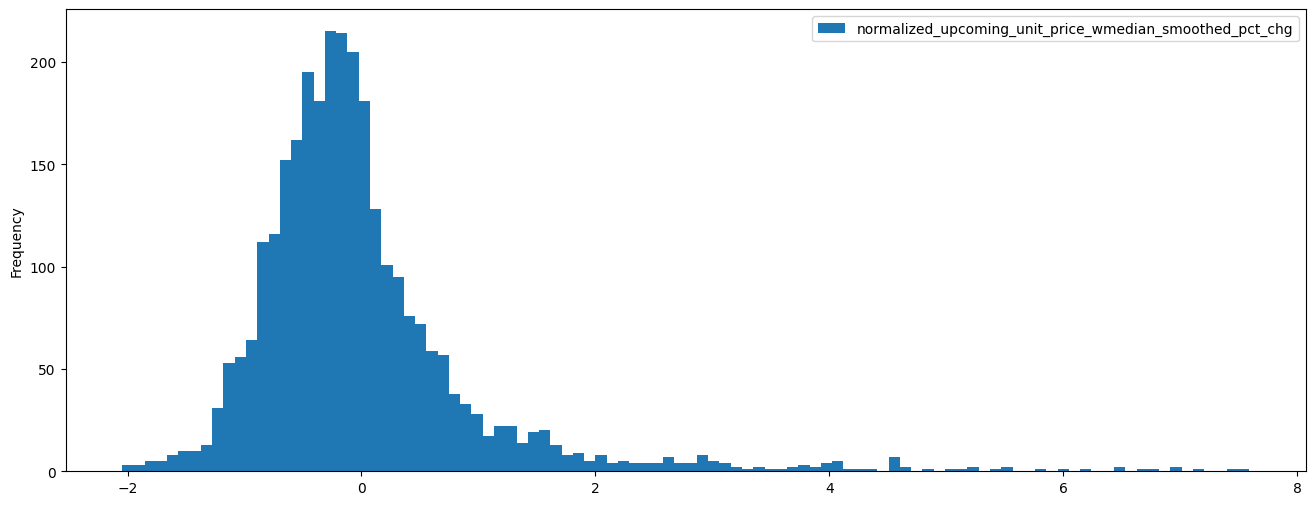

In [203]:
y_test_df.plot.hist(bins=100, figsize=(16, 6))


In [204]:
pretraining_dataset = "plps"
pretrained_model_path = f"{WEIGHTS_DIRECTORY_PATH}/xgb_{pretraining_dataset}_{metric_key}.json"

xgb_regressor = XGBRegressor(
    tree_method="hist", early_stopping_rounds=4, enable_categorical=True
)

# xgb_regressor = XGBRegressor(
#     tree_method="hist", enable_categorical=True
# )

# xgb_regressor.load_model(pretrained_model_path)

In [205]:
xgb_regressor.fit(X_train_df, y_train_df, eval_set=[(X_test_df, y_test_df)])

y_train_pred = xgb_regressor.predict(X_train_df)
y_test_pred = xgb_regressor.predict(X_test_df)

print()
print(f"Train RMSE: {mean_squared_error(y_train_df, y_train_pred, squared=False):.4f}")
print(f"Test RMSE: {mean_squared_error(y_test_df, y_test_pred, squared=False):.4f}")

print(f"Train R2: {r2_score(y_train_df.values.squeeze(), y_train_pred):.4f}")
print(f"Test R2: {r2_score(y_test_df.values.squeeze(), y_test_pred):.4f}")

[0]	validation_0-rmse:0.98882
[1]	validation_0-rmse:0.97755
[2]	validation_0-rmse:0.97608
[3]	validation_0-rmse:0.97111
[4]	validation_0-rmse:0.97377
[5]	validation_0-rmse:0.97165
[6]	validation_0-rmse:0.97190

Train RMSE: 0.8943
Test RMSE: 0.9711
Train R2: 0.1996
Test R2: 0.0563


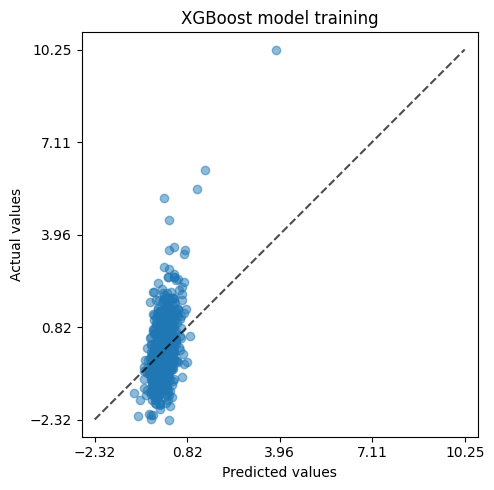

In [206]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_train_df.values.squeeze(),
    y_train_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model training")
plt.tight_layout()

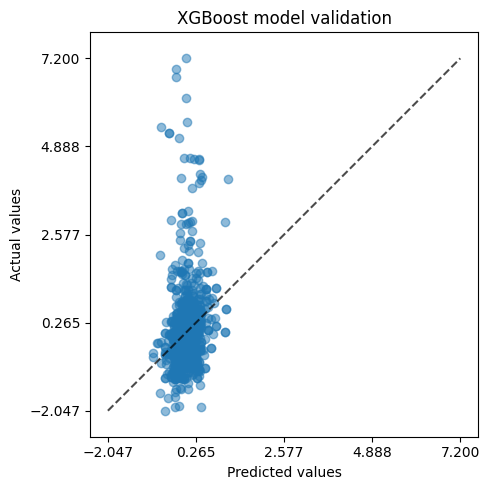

In [207]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test_df.values.squeeze(),
    y_test_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model validation")
plt.tight_layout()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

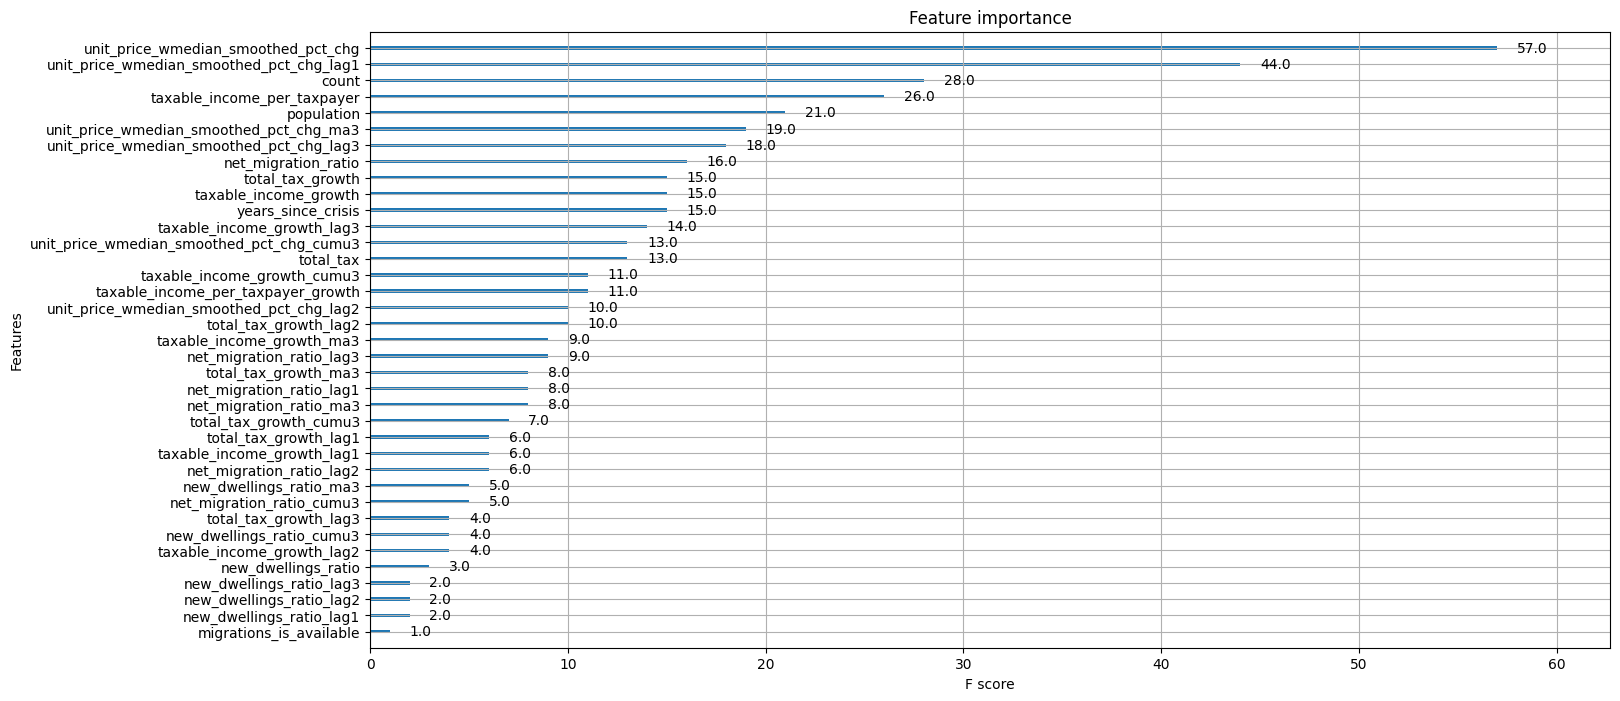

In [184]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_importance(xgb_regressor)